!nvidia-smi

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm

In [2]:
from utils import get_device,set_seed
from trainer import Trainer
from tester import Tester
from dataloader import Cifar10D
from transformations import std_transforms,train_transforms

Device selected cuda


In [3]:
set_seed(mix_precision=True)

In [4]:
device = get_device()
print(device)

cuda


In [5]:
class Model1(nn.Module):
    def __init__(self,norm_name:str,dropout_rate:float):
        super(Model1,self).__init__()

        self.P = nn.MaxPool2d(2,2)
        self.dropout_rate = dropout_rate
        
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=12,kernel_size=1,stride=1,padding=1),
        )

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )
        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        ) 
        self.c7 = nn.Sequential(
           nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1,padding=1)
        ) 

        self.C8 = nn.Sequential(
             nn.Conv2d(in_channels=16,out_channels=40,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )
        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=40,out_channels=40,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        ) 
        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=40,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        ) 

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        
        self.c11 = nn.Conv2d(in_channels=40,out_channels=10,kernel_size=1,stride=1)
    
    def forward(self,x):
        x1 = self.C1(x); x2 = self.C2(x1)
        x = x1+x2     
        
        x = self.c3(x); 
        x = self.P(x)  
        
        x4 = self.C5(self.C4(x)) ; x5 = self.C6(x)
        x = x4+x5
        
        x = self.c7(x)
        x = self.P(x)
        
        x6 = self.C9(self.C8(x));  x7=self.C10(x)
        x = x6+x7
        x = self.gap(x)
        x = self.c11(x)
        return F.log_softmax(x.view(-1,10),dim=1) 


In [6]:
class Module0(nn.Module):
    def __init__(self,norm_name:str,dropout_rate:float=0.01):
        super(Module0,self).__init__()

        self.dropout_rate = dropout_rate
        self.norm_name    = norm_name

        self.conv1 = self.ConvLayer(in_=3,out_=8,k=3,s=1,p=1).extend(
                            self.ConvLayer(in_=8,out_=10,k=3,s=1,p=1)                
                        )
        
        self.trans1 = nn.Sequential(
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(in_channels=10,out_channels=8,kernel_size=1,stride=1,bias=False)
                    )

        self.conv2 = self.ConvLayer(in_=8,out_=8,k=3,s=1,p=1).extend(
                            self.ConvLayer(in_=8,out_=16,k=3,s=1,p=1)
                    )
        
        self.trans2 = nn.Sequential(
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=1,stride=1,bias=False)
                    )
        
        self.conv3 = self.ConvLayer(in_=16,out_=32,k=3,s=1,p=1).extend(
                        self.ConvLayer(in_=32,out_=40,k=3,s=1,p=1)
                        ).extend(
                                self.ConvLayer(in_=40,out_=64,k=3,s=1,p=1)
                        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=10,kernel_size=1,bias=False)
        
    def ConvLayer(
                self,
                in_:int,
                out_:int,
                k:int,
                s:int,
                p:int,
                b=False
    )->torch.nn.modules.container.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels=in_,out_channels=out_,kernel_size=k,stride=s,padding=p,bias=b),
            self.get_norm(out_=out_),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )

    def get_norm(self,out_):
        if self.norm_name=='bn':
            return nn.BatchNorm2d(num_features=out_)
        else:
            raise ValueError('Pass proper normalisation')

    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = self.conv4(x)
        logit = F.log_softmax(x.view(-1,10),dim=1) 
        return logit

In [7]:
cifar10 = Cifar10D(batch_size=128,is_cuda_available=True)

train_loader = cifar10.get_loader(root='../data/',download=False,transform=train_transforms, train=True)
test_loader = cifar10.get_loader(root='../data/',download=False,transform=std_transforms, train=False)

In [8]:
# model = Module0(norm_name='bn',dropout_rate=0.1).to(device) #train=50.37 / test=59.57
model = Model1(norm_name='bn',dropout_rate=0.2).to(device)

In [9]:
# Data to plot accuracy and loss graphs (INIT)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # print(pred.shape)
    # print(target.shape)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


In [10]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
         Dropout2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 12, 34, 34]             204
        MaxPool2d-10           [-1, 12, 17, 17]               0
           Conv2d-11           [-1, 32, 17, 17]           3,488
      BatchNorm2d-12           [-1, 32, 17, 17]              64
             ReLU-13           [-1, 32, 17, 17]               0
        Dropout2d-14           [-1, 32,

In [11]:
%%time

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',verbose=True,patience=3)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test_loss=test(model, device, test_loader, criterion)
  scheduler.step(test_loss)

Epoch 1


Train: Loss=1.8584 Batch_id=390 Accuracy=26.59: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.62it/s]


Test set: Average loss: 1.6905, Accuracy: 3411/10000 (34.1100%)

Epoch 2


Train: Loss=1.5388 Batch_id=390 Accuracy=36.71: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.61it/s]


Test set: Average loss: 1.4506, Accuracy: 4503/10000 (45.0300%)

Epoch 3


Train: Loss=1.5941 Batch_id=390 Accuracy=41.72: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.68it/s]


Test set: Average loss: 1.3332, Accuracy: 5090/10000 (50.9000%)

Epoch 4


Train: Loss=1.6046 Batch_id=390 Accuracy=45.56: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.72it/s]


Test set: Average loss: 1.2389, Accuracy: 5435/10000 (54.3500%)

Epoch 5


Train: Loss=1.4085 Batch_id=390 Accuracy=47.44: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.53it/s]


Test set: Average loss: 1.2245, Accuracy: 5563/10000 (55.6300%)

Epoch 6


Train: Loss=1.3099 Batch_id=390 Accuracy=49.34: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.53it/s]


Test set: Average loss: 1.1959, Accuracy: 5645/10000 (56.4500%)

Epoch 7


Train: Loss=1.3927 Batch_id=390 Accuracy=51.42: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.65it/s]


Test set: Average loss: 1.0852, Accuracy: 6111/10000 (61.1100%)

Epoch 8


Train: Loss=1.3549 Batch_id=390 Accuracy=52.62: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.65it/s]


Test set: Average loss: 1.1496, Accuracy: 5760/10000 (57.6000%)

Epoch 9


Train: Loss=1.2202 Batch_id=390 Accuracy=53.87: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.62it/s]


Test set: Average loss: 1.0453, Accuracy: 6280/10000 (62.8000%)

Epoch 10


Train: Loss=1.3719 Batch_id=390 Accuracy=55.00: 100%|████████████████████████████████| 391/391 [00:39<00:00,  9.86it/s]


Test set: Average loss: 1.0491, Accuracy: 6298/10000 (62.9800%)

Epoch 11


Train: Loss=1.4039 Batch_id=390 Accuracy=55.54: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.71it/s]


Test set: Average loss: 0.9786, Accuracy: 6424/10000 (64.2400%)

Epoch 12


Train: Loss=1.1122 Batch_id=390 Accuracy=56.42: 100%|████████████████████████████████| 391/391 [00:39<00:00,  9.81it/s]


Test set: Average loss: 0.9661, Accuracy: 6496/10000 (64.9600%)

Epoch 13


Train: Loss=1.5024 Batch_id=390 Accuracy=56.64: 100%|████████████████████████████████| 391/391 [00:42<00:00,  9.28it/s]


Test set: Average loss: 1.0124, Accuracy: 6334/10000 (63.3400%)

Epoch 14


Train: Loss=1.2554 Batch_id=390 Accuracy=57.27: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.47it/s]


Test set: Average loss: 0.9234, Accuracy: 6719/10000 (67.1900%)

Epoch 15


Train: Loss=1.1344 Batch_id=390 Accuracy=57.86: 100%|████████████████████████████████| 391/391 [00:42<00:00,  9.31it/s]


Test set: Average loss: 0.9160, Accuracy: 6726/10000 (67.2600%)

Epoch 16


Train: Loss=1.2624 Batch_id=390 Accuracy=58.24: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.43it/s]


Test set: Average loss: 0.9283, Accuracy: 6688/10000 (66.8800%)

Epoch 17


Train: Loss=1.0645 Batch_id=390 Accuracy=58.69: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.9065, Accuracy: 6809/10000 (68.0900%)

Epoch 18


Train: Loss=0.9493 Batch_id=390 Accuracy=58.80: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.61it/s]


Test set: Average loss: 0.8777, Accuracy: 6919/10000 (69.1900%)

Epoch 19


Train: Loss=0.9405 Batch_id=390 Accuracy=59.34: 100%|████████████████████████████████| 391/391 [00:40<00:00,  9.59it/s]


Test set: Average loss: 0.8929, Accuracy: 6768/10000 (67.6800%)

Epoch 20


Train: Loss=0.9864 Batch_id=390 Accuracy=59.86: 100%|████████████████████████████████| 391/391 [00:41<00:00,  9.51it/s]


Test set: Average loss: 0.8766, Accuracy: 6896/10000 (68.9600%)

CPU times: total: 4min 44s
Wall time: 22min 12s


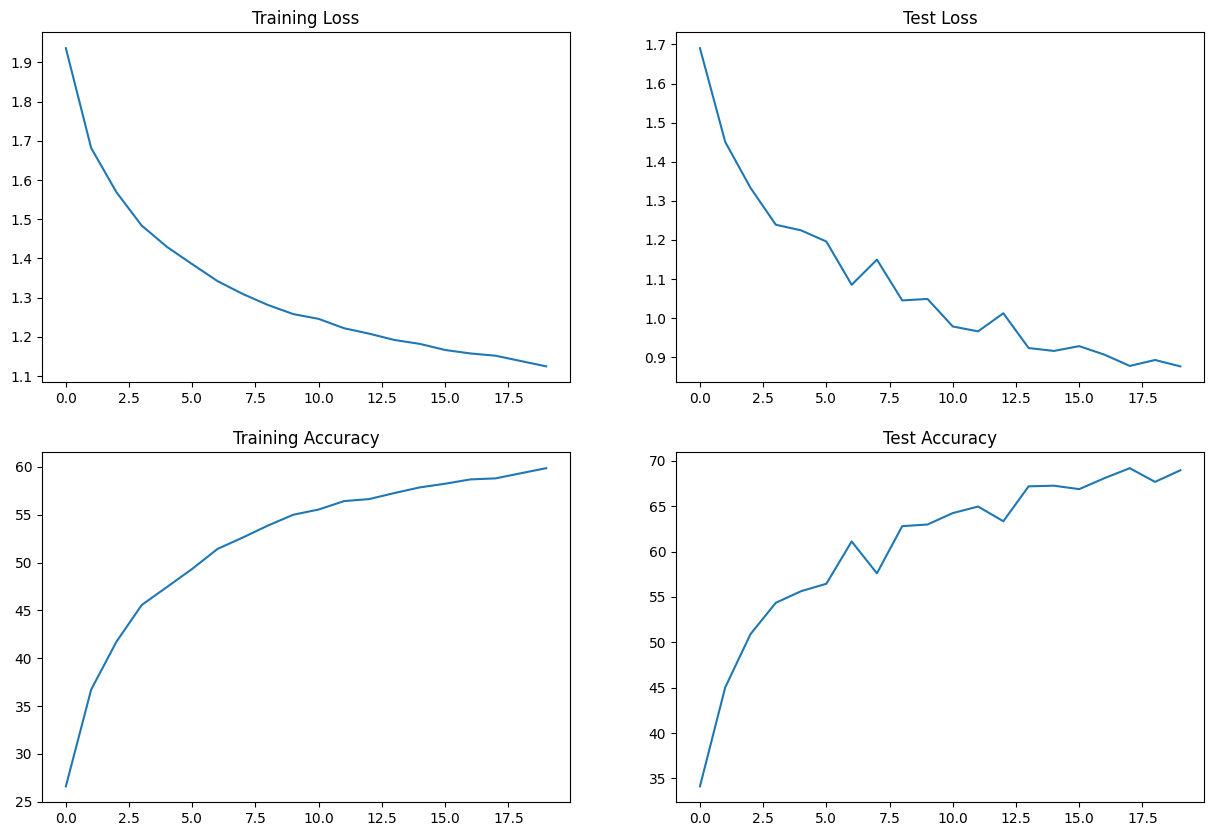

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [13]:
from utils import show_egs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\muthu\Documents\TSAI\session 8\utils.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

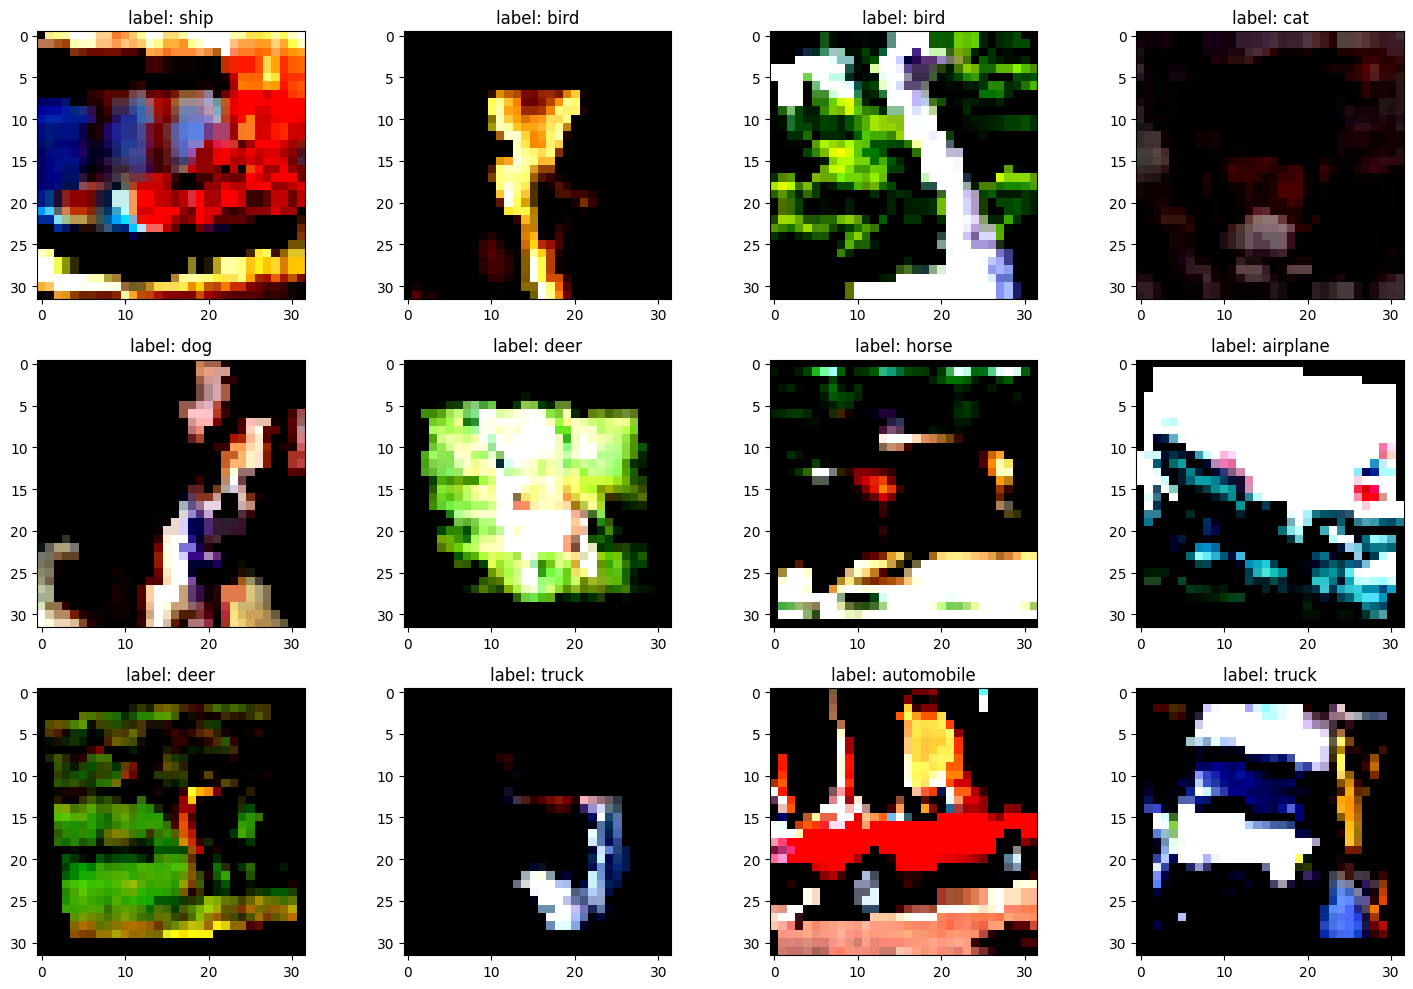

In [14]:
show_egs(train_loader,figsize=(15,10))

In [15]:
def get_misclassified_images(model,test_loader):
    model.eval()
    images = []
    predictions  = []
    labels = []

    with torch.no_grad():
        for inputs,targets in test_loader:
            inputs  = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _,pred = torch.max(outputs,1)

            for i in range(len(pred)):
                if pred[i]!=targets[i]:
                    images.append(inputs[i])
                    predictions.append(pred[i])
                    labels.append(targets[i])
    return images,predictions,labels

In [16]:
imgs, preds, lbls = get_misclassified_images(model,test_loader)

In [17]:
def show_misclassified_images( images, predictions, labels, classes):
    assert len(images) == len(predictions) == len(labels)

    fig = plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        sub = fig.add_subplot(len(images) // 5, 5, i + 1)
        image = images[i]
        image = image.T
        npimg = image.cpu().numpy().squeeze()
        plt.imshow(npimg, cmap="gray")
        predicted = classes[predictions[i]]
        correct = classes[labels[i]]
        sub.set_title(
            "Correct class: {}\nPredicted class: {}".format(correct, predicted)
        )
    plt.tight_layout()

C:\Users\muthu\AppData\Local\Temp\ipykernel_18616\2406507017.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  image = image.T
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cli

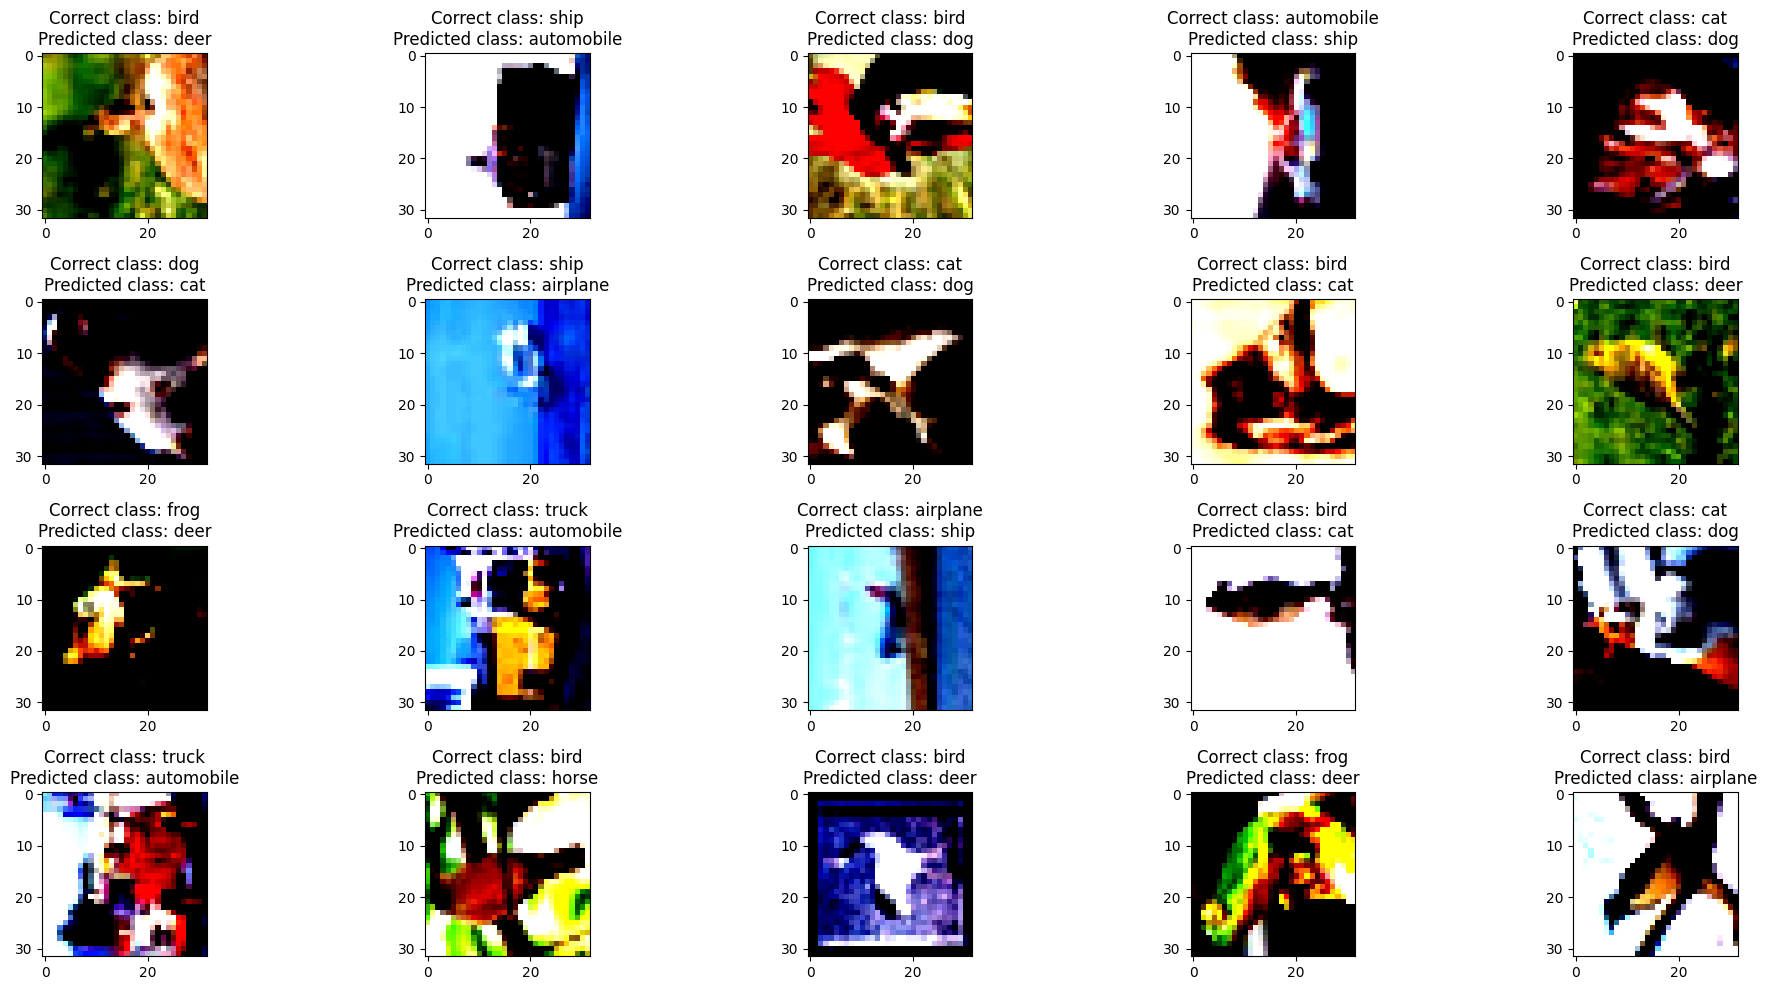

In [18]:
show_misclassified_images(images=imgs[:20],predictions=preds[:20],labels=lbls[:20],classes=cifar10.classes)